Wahlpflichtfach Künstliche Intelligenz II: Praktikum | [Startseite](index.ipynb) | [**<< 09 - Scikit-learn - Maschinelles Lernen**](08%20-%20Scikit-learn%20-%20Maschinelles%20Lernen.ipynb)

---

# 10 - Scikit-learn - Modellauswahl

Unter Modellauswahl ist die Auswahl des ML-Modells zu verstehen, dass die gegebenen Daten bestmöglich erklärt. Da es aber eine Vielzahl an unterschiedlichen Modellen gibt, die wiederum große Parameterbereiche haben, ist diese Aufgabe eine sehr kritische. Wenn zum Beispiel ein Modell ausgewählt wird, das zwar sehr gut auf den Trainingsdaten performt hat, aber auf neuen Daten kläglich versagt, hat dieses die zugrundeliegende Datenverteilung nicht gelernt. 

In diesem Notebook werden wir auf die folgenden Themen wingehen:
- Kreuzvalidierung (Cross-validation)
- Hyperparametertuning
- Metriken und Ergebnisse
- Visualisierung von Ergebnissen

Das Thema Modelauswahl und -evaluierung wird auch sehr ausführlich im [sklearn-Benutzerhandbuch](https://scikit-learn.org/stable/model_selection.html) behandelt.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import datasets

## Kreuzvalidierung
Das Lernen der Parameter einer Vorhersagefunktion und das Testen auf denselben Daten ist ein methodischer Fehler: Ein Modell, das einfach nur die Labels der Stichproben, die es gerade gesehen hat, wiederholen würde, hätte ein perfektes Ergebnis, würde für ungesehenen Daten aber nichts Brauchbares vorhersagen können. Diese Situation wird als Overfitting bezeichnet. Um dies zu vermeiden, ist es bei der Durchführung eines (überwachten) Experiments zum maschinellen Lernen üblich, einen Teil der verfügbaren Daten als Testset vorzuhalten.

### Einfaches Aufteilen der Daten
Um die Daten einfach nur Aufzuteilen, kann die [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)-Methode verwended werden.

In [2]:
from sklearn.model_selection import train_test_split

# load data
X, y = datasets.load_iris(return_X_y=True)
print(X.shape, y.shape)

# split the data into 2 sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(150, 4) (150,)
(90, 4) (90,)
(60, 4) (60,)


Nun kann die Support-Vektor-Maschine mit den Trainingsdaten trainiert werden und mit den Testdaten evaluiert werden.

In [3]:
from sklearn import svm
clf = svm.SVC(kernel='linear', C=0.001).fit(X_train, y_train)
clf.score(X_test, y_test)

0.26666666666666666

Ausprobieren von anderen Werten für C.

In [4]:
clf = svm.SVC(kernel='linear', C=0.01).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8833333333333333

In [5]:
clf = svm.SVC(kernel='linear', C=0.1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9333333333333333

In [6]:
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9666666666666667

### Warum Kreuzvalidierung?
Bei der Auswertung verschiedener Einstellungen ("Hyperparameter") für Vorhersagefunktionen, wie z. B. des C-Werts, die für eine SVM manuell gesetzt werden muss, besteht immer noch die Gefahr des Overfittings auf dem Testset, da die Parameter so lange verändert werden können, bis die Vorhersagefunktionen optimal arbeitet. Auf diese Weise kann das Wissen über das Testset in das Modell "durchsickern" und die Auswertungsmetriken berichten nicht mehr über die Generalisierungsleistung. Um dieses Problem zu lösen, kann ein weiterer Teil des Datensatzes als sogenanntes "Validierungsset" vorgehalten werden: Das Training erfolgt auf dem Trainingsset, danach wird die Auswertung auf dem Validierungsset durchgeführt, und wenn das Experiment erfolgreich zu sein scheint, kann die abschließende Auswertung auf dem Testset erfolgen.

Durch die Aufteilung der verfügbaren Daten in drei Sätze wird jedoch die Anzahl der Datenpunkte, die für das Lernen des Modells verwendet werden können, drastisch reduziert. Außerdem können die Ergebnisse von einer bestimmten zufälligen Wahl für das Paar von (Trainings-, Validierungs-)Sets abhängen.

Um diese Probleme zu überkommen kann das Kreuzvalidierungsverfahren angewandt werden. Bei diesem Verfahren wird immer noch ein Testset benötigt, aber das Validierungsset ist nicht länger nötig. In der Basisversion wird das Trainingsset während des Trainings in $k$ Sets unterteilt. Anschließend wird der Algorithmus $k$ mal auf $k-1$ Sets trainiert. Die Evaluierung des Modells erfolgt dabei auf dem $k$ten Set.

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png">

### Verwendung von Kreuzvalidierung
Der einfachste Weg Kreuzvalidierung zu verwenden ist die [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score)-Hilfsfunktion.

In [7]:
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='linear', C=1, random_state=42)

k = 5
scores = cross_val_score(clf, X, y, cv=k)
scores

array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])

Die Funktion gibt ein Array der Länge $k$ zurück. Jedes Element ist der Score für das jeweilige Teilset.

In [8]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.98 accuracy with a standard deviation of 0.02


Standardmäßig wird als Ergebniss jeder Kreuzvalidierungsiteration der Wert der `score`-Methode des Modells zurückgegeben. Um dies zu ändern, kann der `scoring` Parameter gesetzt werden.

In [9]:
scores = cross_val_score(clf, X, y, cv=5, scoring='f1_macro')
scores

array([0.96658312, 1.        , 0.96658312, 0.96658312, 1.        ])

Einen weiteren Weg Kreuzvalidierung durchzuführen bietet die [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)-Methode. Dieser können, im Gegensatz zur `cross_val_score`-Funktion, mehrere Metriken übergeben werden. Außerdem gibt die Methode zusätzlich zu den Ergebnissen auch Informationen über Laufzeiten zurück. 

In [10]:
from sklearn.model_selection import cross_validate
scoring = ['precision_macro', 'recall_macro']
clf = svm.SVC(kernel='linear', C=1, random_state=0)
scores = cross_validate(clf, X, y, scoring=scoring)
scores

{'fit_time': array([0.00199747, 0.001297  , 0.00107241, 0.000844  , 0.00085258]),
 'score_time': array([0.00215268, 0.00188565, 0.00231504, 0.0021801 , 0.00128675]),
 'test_precision_macro': array([0.96969697, 1.        , 0.96969697, 0.96969697, 1.        ]),
 'test_recall_macro': array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])}

### Kreuzvalidierungsiteratoren
An beide Funktionen kann mit Hilfe des Parameters `cv` entweder ein Integer-Wert $k$ oder ein Kreuzvalidierungsiteratoren übergeben werden. Ersteres resultiert darin, dass der [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) bzw. der [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)-Iterator mit $k$ folds verwendet wird. Im Zweiten fall wird der entsprechende [Kreuzvalidierungsiterator](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators) verwendet, um das Datenset während des Trainings aufzuteilen.

## Hyperparametertuning
Hyperparameter sind all die Parameter, die ein ML-Algorithmus nicht selber lernt. Zum Beispiel ist der `C`-Parameter eines SVMs ein Hyperparameter, den wir vorhin schon einmal manuell optimiert haben. Damit nicht jeder Parameter oder besser gesagt jede Parameterkombination manuell optimiert werden muss, bietet sklearn verschiedene Algorithmen dafür an. Diese Algorithmen suchen im Hyperparameterraum die besten Parameterkombinationen für den ML-Algorithmus. 

### Umfassende Rastersuche (Grid Search)
Die von [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) bereitgestellte Rastersuche generiert umfassend Kandidaten aus einem mit dem Parameter `param_grid` angegebenen Raster von Parameterwerten. Zum Beispiel gibt der folgende `param_grid`

In [11]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

an, dass zwei Raster untersucht werden sollen: eines mit einem linearen Kernel und C-Werten in [1, 10, 100, 1000] und das zweite mit einem RBF-Kernel und dem Kreuzprodukt aus C-Werten im Bereich [1, 10, 100, 1000] und Gamma-Werten in [0,001, 0,0001].

In [12]:
from sklearn.model_selection import GridSearchCV

# create a SVC and optimize it with a grid search
svc = svm.SVC()
clf = GridSearchCV(svc, param_grid)
clf.fit(X, y)

# get the best estimator
clf.best_estimator_

SVC(C=1, kernel='linear')

Anzeigen aller Ergebnisse der Kreuzvalidierung

In [13]:
clf.cv_results_

{'mean_fit_time': array([0.00086436, 0.00065384, 0.00066442, 0.000879  , 0.0012289 ,
        0.0011241 , 0.0007844 , 0.00098586, 0.00053735, 0.00070152,
        0.00048108, 0.00050678]),
 'std_fit_time': array([2.24459746e-04, 3.33382499e-05, 4.65131123e-05, 1.77319795e-04,
        5.41122152e-05, 8.53844007e-05, 1.55605343e-05, 1.82373850e-05,
        1.08509531e-05, 7.07574930e-05, 2.34007076e-05, 9.74499304e-06]),
 'mean_score_time': array([0.00043912, 0.00034084, 0.00032253, 0.00039215, 0.00052447,
        0.00045719, 0.00040145, 0.00042577, 0.00029893, 0.00034914,
        0.00025377, 0.00026832]),
 'std_score_time': array([1.15968365e-04, 2.36285202e-05, 1.76522514e-05, 4.91684549e-05,
        2.51485382e-05, 1.70868792e-05, 9.73542207e-06, 1.52001147e-05,
        1.26405924e-05, 3.62024619e-05, 3.73823302e-06, 2.22943682e-06]),
 'param_C': masked_array(data=[1, 10, 100, 1000, 1, 1, 10, 10, 100, 100, 1000, 1000],
              mask=[False, False, False, False, False, False, False,

### Zufällige Rastersuche
Anstatt die Parameter fest vorzuschreiben können diese auch zufällig aus entsprechenden Verteilungen gezogen werden. Dafür kann die Klasse [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) verwendet werden. Ein beispielhaftes Grid könnte dort wie folgt aussehen.

In [14]:
import scipy

param_grid = {'C': scipy.stats.expon(scale=100), 'gamma': scipy.stats.expon(scale=.1),
  'kernel': ['rbf'], 'class_weight':['balanced', None]}

### Schnellere Rastersuche
Da unter Umständen aus sehr vielen Parametern die besten gefunden werden müssen, gibt es für beide vorherige Varainten auch eine schneller Implementierung. Dabei werden zuerst alle Parameterkombinationen auf einem Bruchteil der Daten trainiert und evaluiert. Anschließend werden die 50% der Parameterkombinationen entfernt, die am schlechtesten abgeschnitten haben. Dann wird die Datenmenge ein wenig erhöht und die nächste Runde beginnt. 

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_successive_halving_iterations_0012.png">

Für eine schnelle, umfassende Suche kann die Klasse [HalvingGridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html) verwendet werden und für eine schnelle, zufällige Suche die Klasse [HalvingRandomSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html).

### Rastersuche und Pipelines
Selbstverständlich kann auch ein Pipeline-Objekt an die Rastersuche übergeben werden. Dafür müssen die Einträge im Parametergrid dann wieder das Format `<estimator>__<parameter>` haben.

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

# create some data
X, y = make_moons()

# setup the pipeline
calibrated_forest = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators=10))
pipe = Pipeline([('select', SelectKBest()), ('model', calibrated_forest)])

# define the parameter grid
param_grid = {
   'select__k': [1, 2],
   'model__base_estimator__max_depth': [2, 4, 6, 8]
}

# fit the best parameters for the whole pipeline
search = GridSearchCV(pipe, param_grid, cv=5).fit(X, y)
search.best_estimator_

/home/delta/project/education/lectures/hsw/wpf-ii-ss2023/venv/lib64/python3.10/site-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/delta/project/education/lectures/hsw/wpf-ii-ss2023/venv/lib64/python3.10/site-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/delta/project/education/lectures/hsw/wpf-ii-ss2023/venv/lib64/python3.10/site-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/delta/project/education/lectures/hsw/wpf-ii-ss2023/venv/lib64/python3.10/site-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/delta/project/education/lectures/h

/home/delta/project/education/lectures/hsw/wpf-ii-ss2023/venv/lib64/python3.10/site-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/delta/project/education/lectures/hsw/wpf-ii-ss2023/venv/lib64/python3.10/site-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/delta/project/education/lectures/hsw/wpf-ii-ss2023/venv/lib64/python3.10/site-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/delta/project/education/lectures/hsw/wpf-ii-ss2023/venv/lib64/python3.10/site-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/delta/project/education/lectures/h

Pipeline(steps=[('select', SelectKBest(k=2)),
                ('model',
                 CalibratedClassifierCV(base_estimator=RandomForestClassifier(max_depth=8,
                                                                              n_estimators=10)))])

## Metriken
Metriken werden zur Evaluation/Validierung von ML-Modellen verwendet. Die folgende Tabelle gibt ein Überblick über die meistverwendeten Scoring-Funktionen. Um beispielsweise in der Kreuzvalidierung eine andere Funktion als die Standardfunktion des ML-Algorithmuses zu verwenden, kann zum Beispiel an das `GridSearchCV`-Objekt einen Wert aus der Spalte _Scoring_ an den Parameter `scoring`übergeben werden. Für Scores gilt generell, je höher der Wert, desto besser. Daher gibt es für Metriken, die zum Beispiel Distanzen messen, negierte Metriken (`neg_mean_squared_error`).

<table class="docutils align-default">
<colgroup>
<col style="width: 31%">
<col style="width: 40%">
<col style="width: 29%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Scoring</p></th>
<th class="head"><p>Function</p></th>
<th class="head"><p>Comment</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p><strong>Classification</strong></p></td>
<td></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘accuracy’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score" title="sklearn.metrics.accuracy_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.accuracy_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘balanced_accuracy’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html#sklearn.metrics.balanced_accuracy_score" title="sklearn.metrics.balanced_accuracy_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.balanced_accuracy_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘top_k_accuracy’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.top_k_accuracy_score.html#sklearn.metrics.top_k_accuracy_score" title="sklearn.metrics.top_k_accuracy_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.top_k_accuracy_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘average_precision’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score" title="sklearn.metrics.average_precision_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.average_precision_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘neg_brier_score’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html#sklearn.metrics.brier_score_loss" title="sklearn.metrics.brier_score_loss"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.brier_score_loss</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘f1’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score" title="sklearn.metrics.f1_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.f1_score</span></code></a></p></td>
<td><p>for binary targets</p></td>
</tr>
<tr class="row-odd"><td><p>‘f1_micro’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score" title="sklearn.metrics.f1_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.f1_score</span></code></a></p></td>
<td><p>micro-averaged</p></td>
</tr>
<tr class="row-even"><td><p>‘f1_macro’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score" title="sklearn.metrics.f1_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.f1_score</span></code></a></p></td>
<td><p>macro-averaged</p></td>
</tr>
<tr class="row-odd"><td><p>‘f1_weighted’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score" title="sklearn.metrics.f1_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.f1_score</span></code></a></p></td>
<td><p>weighted average</p></td>
</tr>
<tr class="row-even"><td><p>‘f1_samples’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score" title="sklearn.metrics.f1_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.f1_score</span></code></a></p></td>
<td><p>by multilabel sample</p></td>
</tr>
<tr class="row-odd"><td><p>‘neg_log_loss’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss" title="sklearn.metrics.log_loss"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.log_loss</span></code></a></p></td>
<td><p>requires <code class="docutils literal notranslate"><span class="pre">predict_proba</span></code> support</p></td>
</tr>
<tr class="row-even"><td><p>‘precision’ etc.</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score" title="sklearn.metrics.precision_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.precision_score</span></code></a></p></td>
<td><p>suffixes apply as with ‘f1’</p></td>
</tr>
<tr class="row-odd"><td><p>‘recall’ etc.</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score" title="sklearn.metrics.recall_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.recall_score</span></code></a></p></td>
<td><p>suffixes apply as with ‘f1’</p></td>
</tr>
<tr class="row-even"><td><p>‘jaccard’ etc.</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html#sklearn.metrics.jaccard_score" title="sklearn.metrics.jaccard_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.jaccard_score</span></code></a></p></td>
<td><p>suffixes apply as with ‘f1’</p></td>
</tr>
<tr class="row-odd"><td><p>‘roc_auc’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score" title="sklearn.metrics.roc_auc_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.roc_auc_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘roc_auc_ovr’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score" title="sklearn.metrics.roc_auc_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.roc_auc_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘roc_auc_ovo’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score" title="sklearn.metrics.roc_auc_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.roc_auc_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘roc_auc_ovr_weighted’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score" title="sklearn.metrics.roc_auc_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.roc_auc_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘roc_auc_ovo_weighted’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score" title="sklearn.metrics.roc_auc_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.roc_auc_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p><strong>Clustering</strong></p></td>
<td></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘adjusted_mutual_info_score’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html#sklearn.metrics.adjusted_mutual_info_score" title="sklearn.metrics.adjusted_mutual_info_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.adjusted_mutual_info_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘adjusted_rand_score’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score" title="sklearn.metrics.adjusted_rand_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.adjusted_rand_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘completeness_score’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html#sklearn.metrics.completeness_score" title="sklearn.metrics.completeness_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.completeness_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘fowlkes_mallows_score’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fowlkes_mallows_score.html#sklearn.metrics.fowlkes_mallows_score" title="sklearn.metrics.fowlkes_mallows_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.fowlkes_mallows_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘homogeneity_score’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html#sklearn.metrics.homogeneity_score" title="sklearn.metrics.homogeneity_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.homogeneity_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘mutual_info_score’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mutual_info_score.html#sklearn.metrics.mutual_info_score" title="sklearn.metrics.mutual_info_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.mutual_info_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘normalized_mutual_info_score’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html#sklearn.metrics.normalized_mutual_info_score" title="sklearn.metrics.normalized_mutual_info_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.normalized_mutual_info_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘rand_score’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html#sklearn.metrics.rand_score" title="sklearn.metrics.rand_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.rand_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘v_measure_score’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html#sklearn.metrics.v_measure_score" title="sklearn.metrics.v_measure_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.v_measure_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p><strong>Regression</strong></p></td>
<td></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘explained_variance’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html#sklearn.metrics.explained_variance_score" title="sklearn.metrics.explained_variance_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.explained_variance_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘max_error’</p></td>
<td><p><a class="reference internal" href="generated/sklearn.metrics.max_error.html#sklearn.metrics.max_error" title="https://scikit-learn.org/stable/modules/sklearn.metrics.max_error"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.max_error</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘neg_mean_absolute_error’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error" title="sklearn.metrics.mean_absolute_error"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.mean_absolute_error</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘neg_mean_squared_error’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error" title="sklearn.metrics.mean_squared_error"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.mean_squared_error</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘neg_root_mean_squared_error’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error" title="sklearn.metrics.mean_squared_error"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.mean_squared_error</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘neg_mean_squared_log_error’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error" title="sklearn.metrics.mean_squared_log_error"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.mean_squared_log_error</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘neg_median_absolute_error’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.median_absolute_error.html#sklearn.metrics.median_absolute_error" title="sklearn.metrics.median_absolute_error"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.median_absolute_error</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘r2’</p></td>
<td><p><a class="reference internal" href="generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score" title="sklearn.metrics.r2_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.r2_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘neg_mean_poisson_deviance’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_poisson_deviance.html#sklearn.metrics.mean_poisson_deviance" title="sklearn.metrics.mean_poisson_deviance"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.mean_poisson_deviance</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘neg_mean_gamma_deviance’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_gamma_deviance.html#sklearn.metrics.mean_gamma_deviance" title="sklearn.metrics.mean_gamma_deviance"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.mean_gamma_deviance</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘neg_mean_absolute_percentage_error’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html#sklearn.metrics.mean_absolute_percentage_error" title="sklearn.metrics.mean_absolute_percentage_error"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.mean_absolute_percentage_error</span></code></a></p></td>
<td></td>
</tr>
</tbody>
</table>

### Accuracy
Die Accuracy gibt den Anteil der korrekt klassifizierten Datenpunkte zurück.

$$ accuracy(y, \hat{y})= \frac{1}{n_{samples}}\sum_{i=0}^{n_{samples}-1}1(\hat{y}_i = y_i) $$

where $1(x)$ is the indicator function.

In [16]:
from sklearn.metrics import accuracy_score
y_pred = [0, 2, 1, 3]
y_true = [0, 1, 2, 3]
accuracy_score(y_true, y_pred)

0.5

Wenn wir nicht normalisieren, bekommen wir die Anzahl an korrekt klassifizierten Datenpunkten zurück.

In [17]:
accuracy_score(y_true, y_pred, normalize=False)

2

Wenn ein Datenpunkt zu mehreren Klassen gehört, müssen alle Klassifizierungen übereinstimmen.

In [18]:
accuracy_score(np.array([[0, 1], [1, 1]]), np.ones((2, 2)))

0.5

### Balanced Accuracy
Die Balanced Accuracy berechnet einen Accuracy-Wert pro Klasse. Dadurch ist sie besser für unausgeglichene Datensets geeignet.

$$ balanced\_accuracy=\frac{1}{2}(\frac{TP}{TP+FN}+\frac{TN}{TN+FP})$$

In [19]:
from sklearn.metrics import balanced_accuracy_score
y_pred = [0, 0, 0, 0]
y_true = [0, 0, 0, 1]
balanced_accuracy_score(y_true, y_pred)

0.5

### Confusion Matrix
In sklearn steht jede Zeile für das wirkliche Label und jede Spalte für das vorhergesagte Label. 

In [20]:
from sklearn.metrics import confusion_matrix
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
confusion_matrix(y_true, y_pred)

array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])

Mit Hilfe der [plot_confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html)-Funktion kann die Matrix visualisiert werden.

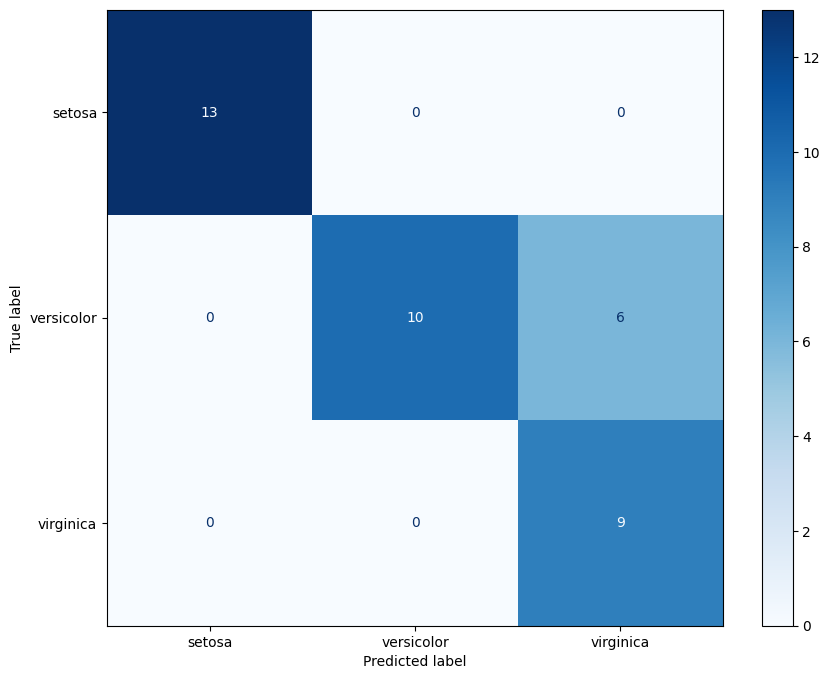

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

# import and split the data
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# define the classifier and fit it
classifier = svm.SVC(kernel='linear', C=0.01).fit(X_train, y_train)

# create the plot
fig, ax = plt.subplots(1, figsize=(10, 8))
_ = ConfusionMatrixDisplay.from_estimator(
    classifier, 
    X_test, 
    y_test, 
    display_labels=iris.target_names, 
    cmap=plt.cm.Blues,
    ax=ax)

### Klassifikationsbericht
Mit der [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)-Funktion ist es möglich sich ein Textbericht, der die wichtigsten Klassifikationsmetriken beinhaltet, zu erzeugen.

In [22]:
from sklearn.metrics import classification_report
y_true = [0, 1, 2, 2, 0]
y_pred = [0, 0, 2, 1, 0]
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.67      1.00      0.80         2
     class 1       0.00      0.00      0.00         1
     class 2       1.00      0.50      0.67         2

    accuracy                           0.60         5
   macro avg       0.56      0.50      0.49         5
weighted avg       0.67      0.60      0.59         5



Weitere Informationen zu den Metriken finden Sie [hier](https://scikit-learn.org/stable/modules/model_evaluation.html#).

## Visualisierung von Ergebnissen
Zur [Visualisierung von Ergebnissen](https://scikit-learn.org/stable/modules/learning_curve.html#) bietet sklearn zwei Helfermethoden. 

### Validtion Curve

Die [validation_curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html)-Methode hilft dabei die Tranings- und Validierungsergebnisse unter Einfluss eines Hyperparameters zu visualisieren.

In [23]:
from sklearn.model_selection import validation_curve

# load and shuffel the data
X, y = datasets.load_iris(return_X_y=True)
indices = np.arange(y.shape[0])
np.random.shuffle(indices)
X, y = X[indices], y[indices]

# collect data for plotting
c_values = [0.5, 1, 2, 3, 4, 5]
train_scores, valid_scores = validation_curve(svm.SVC(kernel='linear'), X, y, 
    param_name='C', param_range=c_values, cv=5)

In [24]:
train_scores

array([[0.99166667, 0.99166667, 0.98333333, 0.96666667, 0.99166667],
       [0.98333333, 0.98333333, 0.99166667, 0.96666667, 0.99166667],
       [0.98333333, 0.98333333, 0.975     , 0.975     , 0.98333333],
       [0.98333333, 0.975     , 0.96666667, 0.975     , 0.975     ],
       [0.98333333, 0.975     , 0.975     , 0.975     , 0.99166667],
       [0.98333333, 0.975     , 0.96666667, 0.975     , 0.99166667]])

In [25]:
valid_scores

array([[1.        , 1.        , 1.        , 1.        , 0.96666667],
       [0.96666667, 0.96666667, 1.        , 1.        , 0.96666667],
       [0.96666667, 0.96666667, 1.        , 1.        , 0.96666667],
       [0.93333333, 0.96666667, 1.        , 1.        , 0.96666667],
       [0.96666667, 0.96666667, 1.        , 1.        , 0.96666667],
       [0.96666667, 0.96666667, 1.        , 1.        , 0.96666667]])

Mit diesen Daten können wir jetzt einen Graphen erstellen.

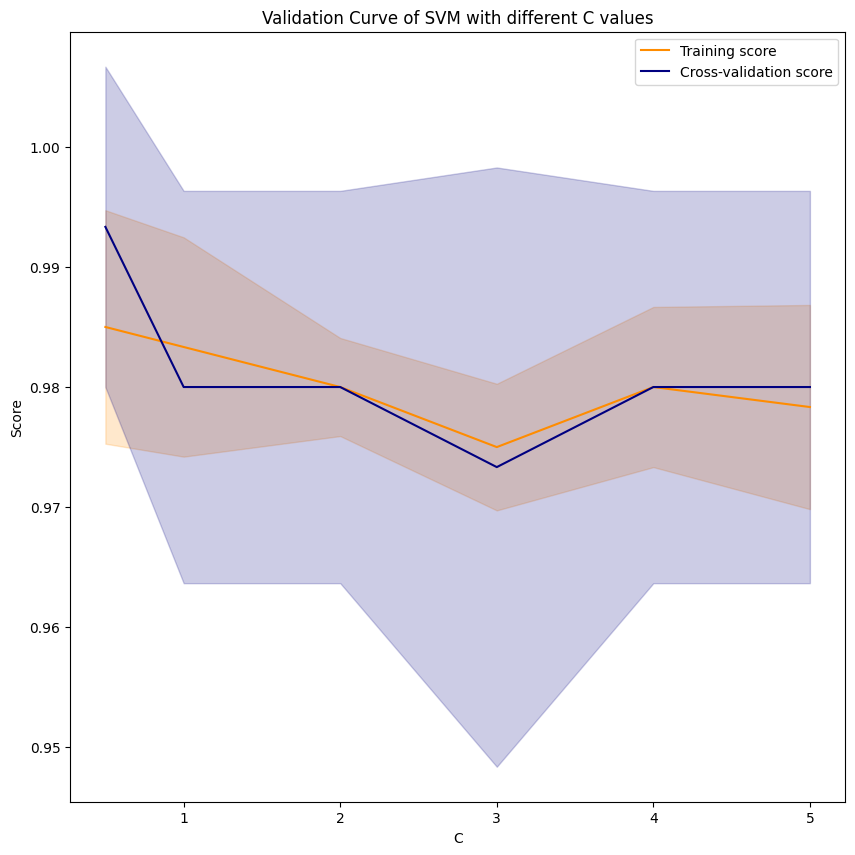

In [26]:
# first, calculate the means and standard deviations
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)
valid_scores_std = valid_scores.std(axis=1)

# create the figure
plt.figure(figsize=(10, 10))
plt.title("Validation Curve of SVM with different C values")
plt.xlabel("C")
plt.ylabel("Score")
# plot the training score
plt.plot(c_values, train_scores_mean, label="Training score", color="darkorange")
plt.fill_between(c_values, 
                 train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, 
                 color="darkorange",
                 alpha=0.2
                )
# plot the validation score
plt.plot(c_values, valid_scores_mean, label="Cross-validation score", color="navy")
plt.fill_between(c_values, 
                 valid_scores_mean - valid_scores_std, 
                 valid_scores_mean + valid_scores_std, 
                 color="navy",
                 alpha=0.2
                )

plt.legend(loc="best")
plt.show()

### Learning Curve
Mit Hilfe der [learing_curve]()-Methode können wir zeigen wie der Validierungs- und Trainingscore sich verändern, wenn unterschiedliche Trainingsdatenmengen verwendet werden.

In [27]:
from sklearn.model_selection import learning_curve

# collect the data
train_sizes, train_scores, valid_scores = learning_curve(
    svm.SVC(kernel='linear'), X, y, train_sizes=np.arange(24, 121, 12), cv=5)
train_sizes

array([ 24,  36,  48,  60,  72,  84,  96, 108, 120])

In [28]:
train_scores

array([[0.95833333, 0.91666667, 0.91666667, 0.91666667, 0.91666667],
       [0.97222222, 0.94444444, 0.91666667, 0.91666667, 0.91666667],
       [0.97916667, 0.97916667, 0.91666667, 0.91666667, 0.91666667],
       [0.98333333, 0.98333333, 0.93333333, 0.93333333, 0.93333333],
       [1.        , 1.        , 0.95833333, 0.95833333, 0.95833333],
       [1.        , 0.98809524, 0.98809524, 0.96428571, 0.96428571],
       [0.98958333, 0.96875   , 0.96875   , 0.95833333, 0.98958333],
       [0.99074074, 0.99074074, 0.98148148, 0.96296296, 0.99074074],
       [0.98333333, 0.98333333, 0.99166667, 0.96666667, 0.99166667]])

In [29]:
valid_scores

array([[0.9       , 0.96666667, 0.96666667, 0.9       , 0.9       ],
       [0.96666667, 0.96666667, 0.96666667, 0.9       , 0.93333333],
       [0.93333333, 0.96666667, 1.        , 0.96666667, 0.93333333],
       [0.93333333, 0.96666667, 1.        , 1.        , 0.9       ],
       [0.96666667, 1.        , 1.        , 1.        , 0.93333333],
       [0.96666667, 1.        , 1.        , 1.        , 0.93333333],
       [0.96666667, 1.        , 1.        , 1.        , 0.93333333],
       [1.        , 1.        , 1.        , 1.        , 0.93333333],
       [0.96666667, 0.96666667, 1.        , 1.        , 0.96666667]])

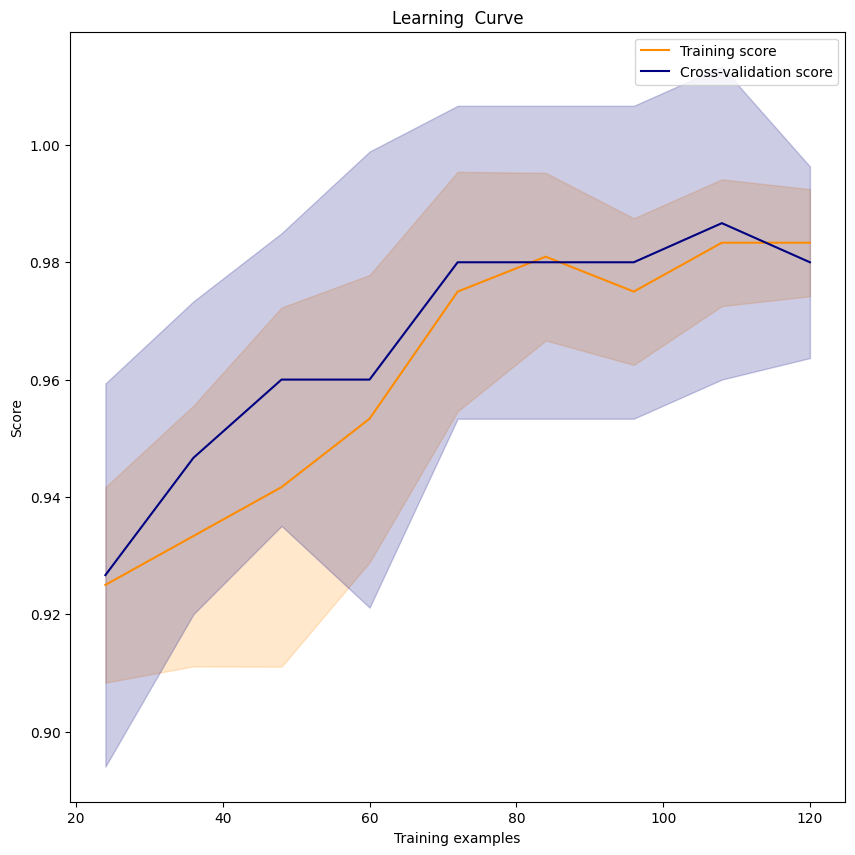

In [30]:
# first, calculate the means and standard deviations
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)
valid_scores_std = valid_scores.std(axis=1)

# create the figure
plt.figure(figsize=(10, 10))
plt.title("Learning  Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
# plot the training score
plt.plot(train_sizes, train_scores_mean, label="Training score", color="darkorange")
plt.fill_between(train_sizes, 
                 train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, 
                 color="darkorange",
                 alpha=0.2
                )
# plot the validation score
plt.plot(train_sizes, valid_scores_mean, label="Cross-validation score", color="navy")
plt.fill_between(train_sizes, 
                 valid_scores_mean - valid_scores_std, 
                 valid_scores_mean + valid_scores_std, 
                 color="navy",
                 alpha=0.2
                )

plt.legend(loc="best")
plt.show()

---

Wahlpflichtach Künstliche Intelligenz II: Praktikum | [Startseite](index.ipynb) | [**>> t.b.d.**]()